<a href="https://colab.research.google.com/github/LSzubelak/ls-projects/blob/main/Impact_500_program/500%2B_program_child_poverty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install eurostat
!pip install pycountry


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 59.5 MB/s eta 0:00:00


In [4]:
import eurostat
import pycountry
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
df_wide = eurostat.get_data_df("ilc_peps01")
df = df_wide.reset_index()

In [13]:
df = df[df["age"] == "Y_LT18"]
df

,index,freq,unit,age,sex,geo\TIME_PERIOD,2003,2004,2005,2006,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
3915,3915,A,PC,Y_LT18,F,AL,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,56.6,53.2,50.3,50.1
3916,3916,A,PC,Y_LT18,F,AT,17.1,20.2,18.9,19.4,...,21.6,19.5,22.6,23.7,21.5,20.1,23.7,21.8,20.6,19.8
3917,3917,A,PC,Y_LT18,F,BE,23.7,22.6,23.3,19.4,...,23.1,21.9,21.7,22.5,23.4,23.5,23.5,22.7,20.6,18.7
3918,3918,A,PC,Y_LT18,F,BG,NaN,NaN,NaN,59.5,...,51.9,52.0,53.8,47.0,42.9,46.0,41.7,34.9,35.3,34.8
3919,3919,A,PC,Y_LT18,F,CH,NaN,NaN,NaN,NaN,...,19.1,19.9,16.8,18.4,20.0,19.8,19.2,19.2,19.5,20.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8676,8676,A,THS_PER,Y_LT18,T,SI,NaN,NaN,54.0,52.0,...,65.0,61.0,66.0,67.0,63.0,57.0,58.0,50.0,45.0,47.0
8677,8677,A,THS_PER,Y_LT18,T,SK,NaN,NaN,387.0,324.0,...,231.0,233.0,252.0,223.0,237.0,238.0,218.0,239.0,217.0,192.0
8678,8678,A,THS_PER,Y_LT18,T,TR,NaN,NaN,NaN,16579.0,...,15754.0,15313.0,13117.0,11024.0,10832.0,11597.0,11136.0,10988.0,10998.0,11235.0
8679,8679,A,THS_PER,Y_LT18,T,UK,NaN,NaN,3982.0,3830.0,...,3436.0,4002.0,4180.0,4024.0,3942.0,3553.0,3773.0,3972.0,NaN,NaN


## Child poverty

In [42]:
import re
import eurostat
import pandas as pd
import pycountry

# Download the at-risk-of-poverty rate by age and sex
df_wide = eurostat.get_data_df("ilc_peps01")
df = df_wide.reset_index()

# Rename geo column
geo_col = [c for c in df.columns if 'geo' in c.lower()][0]
df = df.rename(columns={geo_col: "geo"})

# Filter for age group: less than 18 years
df = df[df["age"] == "Y_LT18"]

# Filter for percentage units of measurement
df = df[df["unit"] == "PC"]

# Filter for gender
df = df[df["sex"] == "T"]

# Drop unneeded dimensions
df = df.drop(columns=["age", "sex", "unit", "indic_il", "freq"], errors="ignore")

# Identify true year columns (four digits only)
year_cols = [c for c in df.columns if re.fullmatch(r"\d{4}", str(c))]

# Melt into long form
df_long = df.melt(
    id_vars=["geo"],
    value_vars=year_cols,
    var_name="Year",
    value_name="Child Poverty Rate"
)

# Country code mapping fallback
_manual = {
    "EL": "Greece",
    "UK": "United Kingdom",
    "XK": "Kosovo",
    "EU27_2020": "European Union (27 countries)",
    "EA19": "Euro Area (19 countries)",
}

def code_to_name(code):
    if code in _manual:
        return _manual[code]
    try:
        return pycountry.countries.get(alpha_2=code).name
    except:
        return code  # fallback: return raw code

# Map geo codes to country names
df_long["Country"] = df_long["geo"].apply(code_to_name)

# Clean and format
df_long["Year"] = df_long["Year"].astype(int)
df_clean = (
    df_long
    .dropna(subset=["Child Poverty Rate"])
    [["Country", "Year", "Child Poverty Rate"]]
    .sort_values(["Country", "Year"])
    .reset_index(drop=True)
)

# Preview data
print(df_clean.head(10))


   Country  Year  Child Poverty Rate
0  Albania  2017                54.8
1  Albania  2018                52.4
2  Albania  2019                49.4
3  Albania  2020                48.4
4  Austria  2003                17.8
5  Austria  2004                19.7
6  Austria  2005                19.1
7  Austria  2006                19.3
8  Austria  2007                18.5
9  Austria  2008                22.9


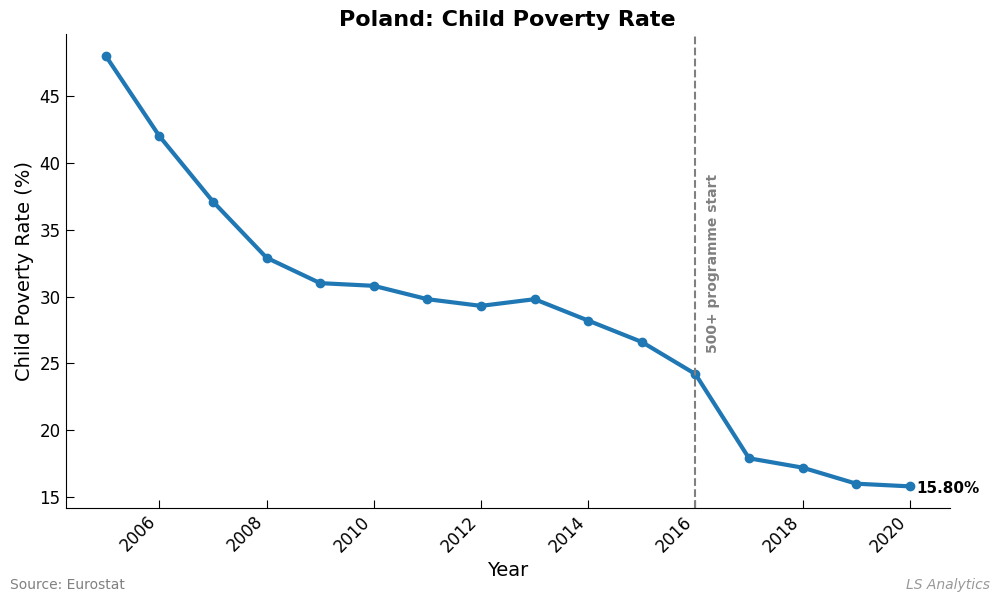

In [70]:
import matplotlib.pyplot as plt

# Subset to Poland
df_pl = df_clean[df_clean['Country'] == 'Poland']

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot line for child poverty rate
ax.plot(
    df_pl['Year'],
    df_pl['Child Poverty Rate'],
    marker='o',
    linewidth=3,
    markersize=6,
    color='#1f77b4',
    label='Child Poverty Rate'
)

# Highlight the start of the 500+ program (April 2016)
ax.axvline(2016, linestyle='--', linewidth=1.5, color='gray')
ax.text(
    2016 + 0.2,
    df_pl['Child Poverty Rate'].min() + 10,
    '500+ programme start',
    rotation=90,
    va='bottom',
    fontweight='bold',
    color='gray'
)

# Annotate the final point value
last_year = df_pl['Year'].max()
last_value = df_pl.loc[df_pl['Year'] == last_year, 'Child Poverty Rate'].values[0]
ax.annotate(
    f'{last_value:.2f}%',
    xy=(last_year, last_value),
    xytext=(5, -5),
    textcoords='offset points',
    fontweight='bold',
    fontsize=11
)

# Styling
ax.set_title('Poland: Child Poverty Rate', fontsize=16, fontweight='bold')
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Child Poverty Rate (%)', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(direction='in', length=6, labelsize=12)
plt.xticks(rotation=45, ha='right')

# Remove grid for clean visual
ax.grid(False)

# Add Eurostat source and LS Analytics watermark
fig.text(0.01, 0.01, 'Source: Eurostat', fontsize=10, color='gray')
fig.text(0.99, 0.01, 'LS Analytics', fontsize=10, color='gray',
         ha='right', fontstyle='italic', alpha=0.8)

plt.tight_layout()
# Optional: save as high-quality image
# plt.savefig('poland_child_poverty_lsanalytics.png', dpi=300)
plt.show()


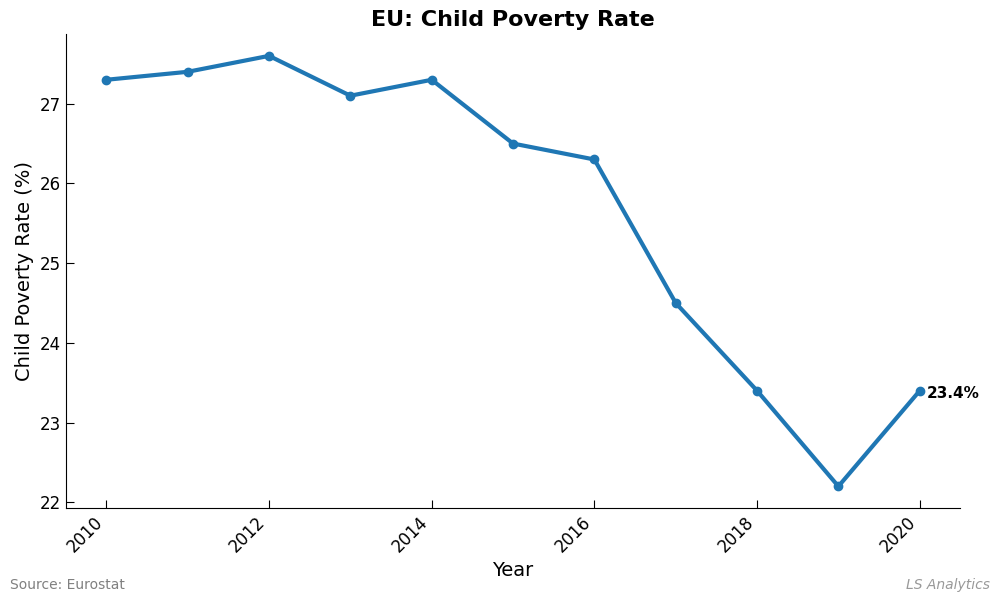

In [72]:
import matplotlib.pyplot as plt

# 1. Subset to EU27
df_eu = df_clean[df_clean["Country"] == "European Union (27 countries)"].copy()

# 2. Create the chart
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(
    df_eu["Year"],
    df_eu["Child Poverty Rate"],
    marker="o",
    linewidth=3,
    markersize=6,
    color="#1f77b4",
    label="Child Poverty Rate"
)

# 3. Annotate the final value
last_year  = df_eu["Year"].max()
last_value = df_eu.loc[df_eu["Year"] == last_year, "Child Poverty Rate"].iloc[0]
ax.annotate(
    f"{last_value:.1f}%",
    xy=(last_year, last_value),
    xytext=(5, -5),
    textcoords="offset points",
    fontweight="bold",
    fontsize=11
)

# 4. Styling
ax.set_title("EU: Child Poverty Rate",
             fontsize=16, fontweight="bold")
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel('Child Poverty Rate (%)', fontsize=14)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(direction="in", length=6, labelsize=12)
plt.xticks(rotation=45, ha='right')

# Remove grid for minimalist look
ax.grid(False)

# 5. Add source and watermark
fig.text(0.01, 0.01, "Source: Eurostat", fontsize=10, color="gray")
fig.text(0.99, 0.01, "LS Analytics", fontsize=10, color="gray",
         ha="right", fontstyle="italic", alpha=0.8)

plt.tight_layout()
# Optional: save to file
# plt.savefig("eu27_child_poverty_lsanalytics.png", dpi=300)
plt.show()


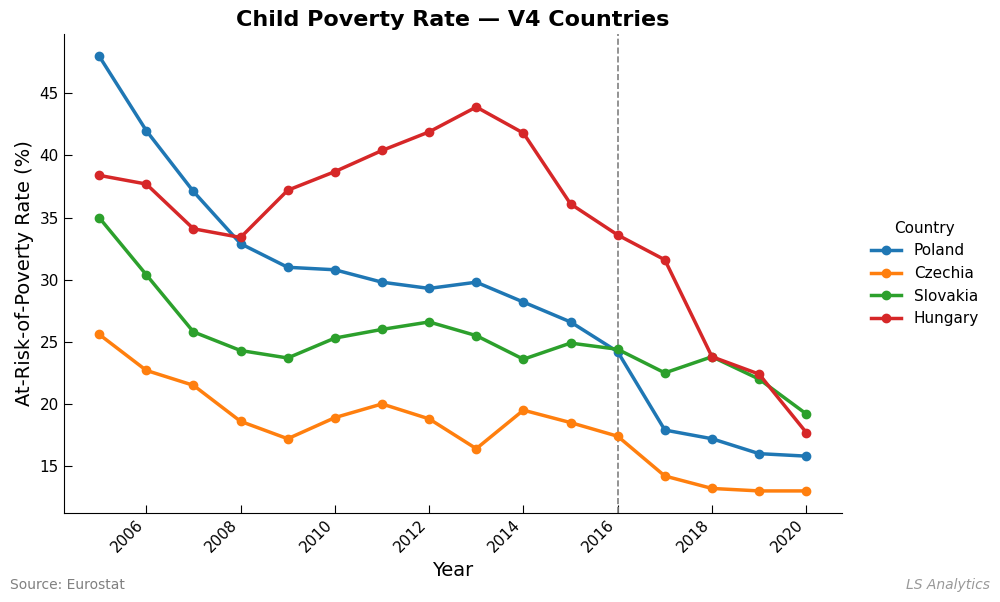

In [77]:
import matplotlib.pyplot as plt

# --- 1. V4 subset ----------------------------------------------------------
neighbors = ['Poland', 'Czechia', 'Slovakia', 'Hungary']
df_did = df_clean[df_clean['Country'].isin(neighbors)].copy()

# --- 2. Figure & palette ---------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))
palette = {
    'Poland':   '#1f77b4',   # blue
    'Czechia':  '#ff7f0e',   # orange
    'Slovakia': '#2ca02c',   # green
    'Hungary':  '#d62728'    # red
}

# --- 3. Plot each country ---------------------------------------------------
for country in neighbors:
    d = df_did[df_did['Country'] == country]
    ax.plot(
        d['Year'], d['Child Poverty Rate'],
        marker='o',
        markersize=6,
        linewidth=2.5,
        color=palette[country],
        label=country,
        zorder=3
    )

# --- 4. Policy marker -------------------------------------------------------
ax.axvline(2016, color='gray', linestyle='--', linewidth=1.2)
ax.text(2016 + .2, ax.get_ylim()[0] + 1,
        '', rotation=90,
        va='bottom', color='gray', fontweight='bold', fontsize=10)

# --- 5. Styling -------------------------------------------------------------
ax.set_title('Child Poverty Rate — V4 Countries', fontsize=16, fontweight='bold')
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('At‑Risk‑of‑Poverty Rate (%)', fontsize=14)
ax.tick_params(direction='in', length=6, labelsize=11)
plt.xticks(rotation=45, ha='right')

# Minimalist look — only y‑axis grid
ax.grid(False)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Legend — outside to the right
ax.legend(title='Country', fontsize=11, title_fontsize=11,
          frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5))

# --- 6. Source & watermark --------------------------------------------------
fig.text(0.01, 0.01, 'Source: Eurostat', fontsize=10, color='gray')
fig.text(0.99, 0.01, 'LS Analytics', fontsize=10, color='gray',
         ha='right', alpha=0.8, fontstyle='italic')

plt.tight_layout()
# plt.savefig('v4_child_poverty_trend.png', dpi=300)
plt.show()


In [33]:
import statsmodels.formula.api as smf
from statsmodels.tools.tools import add_constant


# 1. Subset to Poland and its neighbors
neighbors = ['Poland', 'Czechia', 'Slovakia', 'Hungary']
df_did = df_clean[df_clean['Country'].isin(neighbors)].copy()

# 2. Create DiD covariates
df_did['treated'] = (df_did['Country'] == 'Poland').astype(int)
df_did['post']    = (df_did['Year'] >= 2016).astype(int)
df_did['did']     = df_did['treated'] * df_did['post']

# 3. Run OLS with country & year fixed effects
#    We use Q("Child Poverty Rate") to handle the space in the variable name
formula = 'Q("Child Poverty Rate") ~ treated + post + did + C(Country) + C(Year)'
model = smf.ols(formula, data=df_did).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_did['Country']}
)

# 4. Output results
print(model.summary())


                               OLS Regression Results                              
Dep. Variable:     Q("Child Poverty Rate")   R-squared:                       0.874
Model:                                 OLS   Adj. R-squared:                  0.820
Method:                      Least Squares   F-statistic:                     5.748
Date:                     Sat, 19 Jul 2025   Prob (F-statistic):             0.0924
Time:                             10:54:49   Log-Likelihood:                -162.32
No. Observations:                       64   AIC:                             364.6
Df Residuals:                           44   BIC:                             407.8
Df Model:                               19                                         
Covariance Type:                   cluster                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 21, but rank is 3
  warnings.warn('covariance of constraints does not have full '


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from toolz import partial
from scipy.optimize import fmin_slsqp

# ---------------------------------------------------------------------
# 1.  Synthetic‑control estimator with weight regularisation
# ---------------------------------------------------------------------
class SyntheticControlWithWeights:
    """Classic SCM with L2‑penalty toward uniform weights and simplex constraints."""

    def loss(self, W, X, y, reg):
        mse      = np.mean((y - X @ W)**2)
        penalty  = reg * np.sum((W - 1 / X.shape[1])**2)
        return np.sqrt(mse + penalty)

    def fit(self, X, y, regularization_weight=0.0):
        w0 = np.ones(X.shape[1]) / X.shape[1]                    # uniform start
        self.coef_ = fmin_slsqp(
            func     = partial(self.loss, X=X, y=y, reg=regularization_weight),
            x0       = w0,
            f_eqcons = lambda w: np.sum(w) - 1,                  # Σw = 1
            bounds   = [(0, 1)] * len(w0),                       # 0 ≤ w ≤ 1
            disp     = False
        )
        self.mse_ = self.loss(self.coef_, X, y, regularization_weight)
        return self

    def predict(self, X):
        return X @ self.coef_



In [44]:
df_pl

,Country,Year,Child Poverty Rate
489,Poland,2005,48.0
490,Poland,2006,42.0
491,Poland,2007,37.1
492,Poland,2008,32.9
493,Poland,2009,31.0
494,Poland,2010,30.8
495,Poland,2011,29.8
496,Poland,2012,29.3
497,Poland,2013,29.8
498,Poland,2014,28.2


In [61]:
# --------------------------------------------------------------------
# 2.  Build a balanced donor panel (all countries except Poland & aggregates)
# --------------------------------------------------------------------
TREATED       = "Poland"
T0            = 2015  # last pre-treatment year
AGG_CODES     = {"EU27_2020", "EA19", "EA20", "FX", "EA", "EA18", "EU27_2007", "EU28", "EU", 'Euro Area (19 countries)', 'European Union (27 countries)'}

# 1. Create wide format Year × Country matrix (child poverty rate)
wide = (
    df_clean
    .loc[~df_clean['Country'].isin(AGG_CODES)]  # drop aggregates
    .pivot(index='Year', columns='Country', values='Child Poverty Rate')
    .sort_index()
)

# 2. Filter only years 2010 and later
wide = wide[wide.index >= 2010]

# 3. Drop countries or years with missing data
wide_bal = wide.dropna(axis=1)  # drop countries with missing values
wide_bal = wide_bal.dropna()    # drop years with missing values

# 4. Identify donor countries (exclude treated)
donors = [c for c in wide_bal.columns if c != TREATED]

# 5. Report dimensions
print(f"Balanced panel: {wide_bal.shape[0]} years × "
      f"{wide_bal.shape[1]} units ({len(donors)} donors + Poland)")

# Pre‑treatment matrices
X_pre = wide_bal.loc[:T0, donors].values
y_pre = wide_bal.loc[:T0, TREATED].values

# Full‑period matrices
X_full = wide_bal[donors]
y_full = wide_bal[TREATED]

Balanced panel: 11 years × 32 units (31 donors + Poland)


In [62]:
# ---------------------------------------------------------------------
# 3.  Fit SCM weights with a small regularisation penalty
# ---------------------------------------------------------------------
scm = SyntheticControlWithWeights().fit(X_pre, y_pre, regularization_weight=0.001)

synthetic = X_full @ scm.coef_
gap       = y_full - synthetic
ate       = gap.loc[2016:].mean()

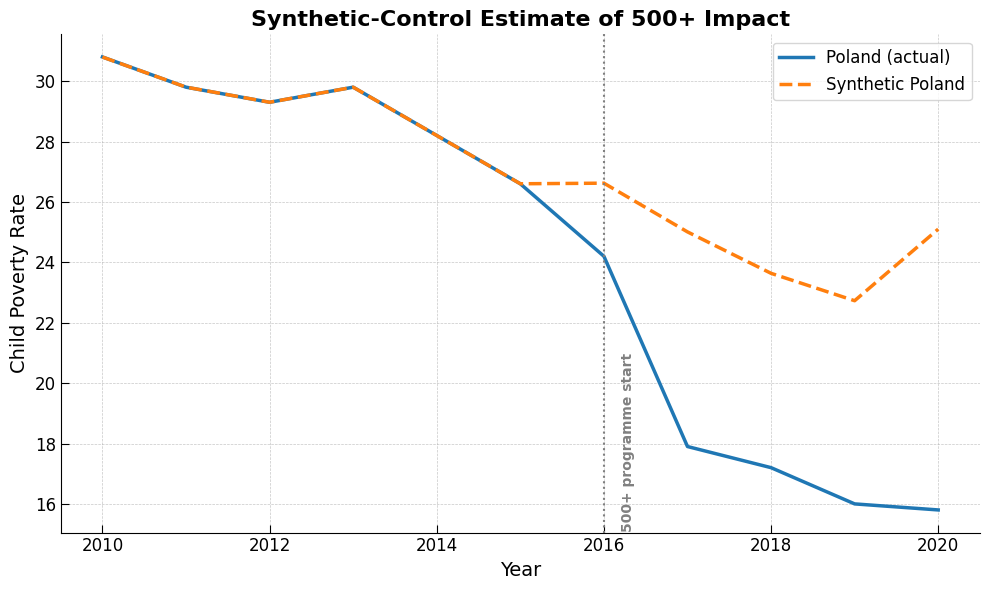

In [63]:
# --------------------------------------------------------------------
# 4.  Plot actual vs. synthetic Poland
# --------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(wide_bal.index, y_full,    label='Poland (actual)', linewidth=2.5)
ax.plot(wide_bal.index, synthetic, '--', label='Synthetic Poland', linewidth=2.5)

ax.axvline(2016, color='gray', linestyle=':', linewidth=1.5)
ax.text(2016 + .2, ax.get_ylim()[0] + .03, '500+ programme start',
        rotation=90, va='bottom', color='gray', fontweight='bold')

ax.set_title('Synthetic‑Control Estimate of 500+ Impact',
             fontsize=16, fontweight='bold')
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Child Poverty Rate', fontsize=14)
ax.grid(True, linestyle='--', linewidth=.5, alpha=.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(fontsize=12)
ax.tick_params(direction='in', length=6, labelsize=12)

plt.tight_layout()
# plt.savefig('synthetic_poland_all_donors.png', dpi=300)
plt.show()

In [64]:

# ---------------------------------------------------------------------
# 5.  Display weights and ATE
# ---------------------------------------------------------------------
weights = pd.Series(scm.coef_, index=donors).sort_values(ascending=False)
print("\nDonor weights (SLSQP):")
print(weights)

print(f"\nAverage post‑2016 treatment effect (ATE): {ate:.3f} children per woman")


Donor weights (SLSQP):
Germany            4.202873e-01
Luxembourg         1.520223e-01
Portugal           1.171737e-01
Hungary            1.119975e-01
Türkiye            1.118976e-01
Lithuania          6.514451e-02
Norway             2.147719e-02
Bulgaria           4.706624e-17
Czechia            3.700594e-17
Estonia            3.070082e-17
Denmark            2.763465e-17
France             2.326642e-17
Latvia             2.097931e-17
Austria            1.685432e-17
Malta              1.525490e-17
Slovenia           1.203411e-17
Spain              1.070215e-17
Sweden             1.016316e-17
Romania            8.597551e-18
Italy              5.653330e-18
Cyprus             3.498642e-18
Iceland            1.737351e-18
Belgium            0.000000e+00
Ireland            0.000000e+00
Greece             0.000000e+00
Finland            0.000000e+00
Croatia            0.000000e+00
North Macedonia    0.000000e+00
Netherlands        0.000000e+00
Slovakia           0.000000e+00
Switzerland     

           unit  rmspe_pre  rmspe_post         ratio
29       Sweden   0.000340    3.858760  11359.104446
26     Slovakia   0.000144    1.476581  10223.855256
2       Belgium   0.000144    1.256641   8723.646620
0        Poland   0.001333    6.775474   5080.998282
21  Netherlands   0.000445    1.136038   2550.901615


/tmp/ipython-input-65-3117184799.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(placebo_df["unit"], rotation=45, ha="right", fontsize=10)


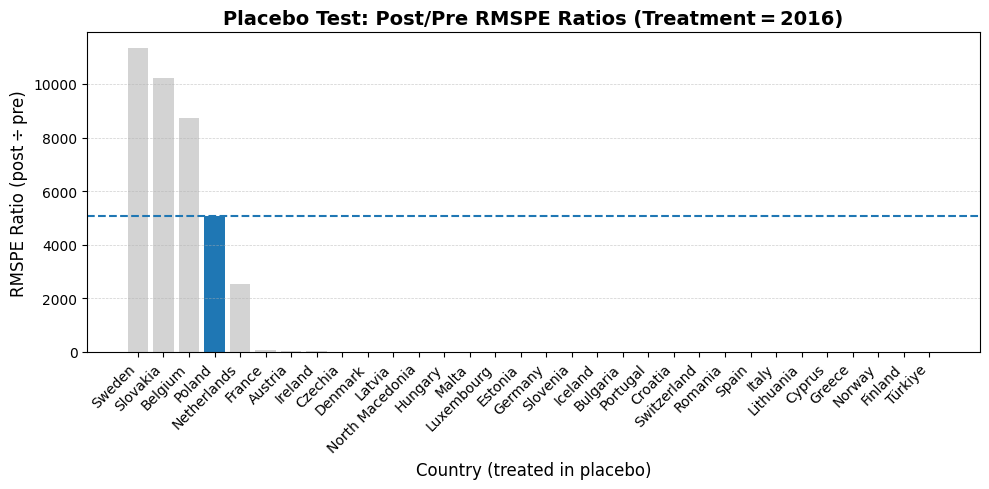


Poland's RMSPE ratio rank: 4 out of 32


In [65]:
"""
PLACEBO (IN‐SPACE) TEST
-----------------------
Repeats the synthetic‐control construction for *every* country in the balanced
panel, pretending each one is “treated” in 2016.  Compares Poland’s post‑/pre‑
RMSPE ratio to the distribution of placebo ratios.

Assumes the *balanced* wide matrix `wide_bal`, donor list `donors`,
treated unit name `TREATED`, and class `SyntheticControlWithWeights`
have already been created (see previous snippet).
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1. Helper: fit SCM for a given unit and return pre/post RMSPE
# ------------------------------------------------------------------
def scm_rmspe_ratio(unit, reg=0.001):
    donor_pool = [c for c in wide_bal.columns if c != unit]

    # Pre‑treatment fit
    X_pre = wide_bal.loc[:T0, donor_pool].values
    y_pre = wide_bal.loc[:T0, unit].values

    model = SyntheticControlWithWeights().fit(X_pre, y_pre, regularization_weight=reg)

    # Synthetic series over full horizon
    synthetic = wide_bal[donor_pool] @ model.coef_
    gap = wide_bal[unit] - synthetic

    rmspe_pre  = np.sqrt(np.mean(gap.loc[:T0]**2))
    rmspe_post = np.sqrt(np.mean(gap.loc[2016:]**2))

    return rmspe_pre, rmspe_post, rmspe_post / rmspe_pre

# ------------------------------------------------------------------
# 2. Run placebo for every unit (treated + donors)
# ------------------------------------------------------------------
placebo_rows = []
for unit in [TREATED] + donors:
    pre, post, ratio = scm_rmspe_ratio(unit)
    placebo_rows.append({
        "unit":  unit,
        "rmspe_pre":  pre,
        "rmspe_post": post,
        "ratio":      ratio
    })

placebo_df = pd.DataFrame(placebo_rows).sort_values("ratio", ascending=False)
print(placebo_df.head())

# ------------------------------------------------------------------
# 3. Plot distribution of RMSPE ratios (Poland highlighted)
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(
    x=placebo_df["unit"],
    height=placebo_df["ratio"],
    color=["#1f77b4" if u == TREATED else "lightgray" for u in placebo_df["unit"]]
)
ax.axhline(placebo_df.loc[placebo_df["unit"] == TREATED, "ratio"].values[0],
           color="#1f77b4", linestyle="--")

ax.set_title("Placebo Test: Post/Pre RMSPE Ratios (Treatment = 2016)",
             fontsize=14, fontweight="bold")
ax.set_ylabel("RMSPE Ratio (post ÷ pre)", fontsize=12)
ax.set_xlabel("Country (treated in placebo)", fontsize=12)
ax.set_xticklabels(placebo_df["unit"], rotation=45, ha="right", fontsize=10)
ax.grid(True, axis="y", linestyle="--", linewidth=.5, alpha=.6)
plt.tight_layout()
# plt.savefig("placebo_rmspe_ratios.png", dpi=300)
plt.show()

# ------------------------------------------------------------------
# 4. Where does Poland sit?
# ------------------------------------------------------------------
rank = placebo_df.reset_index(drop=True)
poland_rank = rank.index[rank["unit"] == TREATED][0] + 1
print(f"\nPoland's RMSPE ratio rank: {poland_rank} out of {len(rank)}")
